In [3]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import difflib
import sys
import os
import glob

from tqdm.auto import tqdm
from pprint import pprint

import plotnine
from plotnine import *

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

In [4]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

Mounted at /content/G_drive


In [5]:
# change dir, append sys_path, and import custom moduls
path = '/content/G_drive/MyDrive/Colab Notebooks/Paper_3/Earth_Engine_codes/Step_3_Scenarios'
% cd {path}
sys.path.append('../Step_2_Sort_GAEZ_layers/Modules')

from Modules import get_img_df,filter_exclude, stats_GAEZ_Yearbook
# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

/content/G_drive/MyDrive/Colab Notebooks/Paper_3/Earth_Engine_codes/Step_3_Scenarios


In [6]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [7]:
# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

### 1） Compute the crop achievement ratio

#### 1-1) using GYGA data:

In [ ]:
# set the coet-effetive percentage
cost_effective_pct = 0.8

In [ ]:
# read GYGA (global yield gap atlas) data
GYGA = pd.read_csv('../../Data/06_Yearbook/Agricultural_production/GYGA/GygaChina_Crop_potential_yield.csv')

# split station_name into city_name and province_name
GYGA['City'] = GYGA['STATIONNAME'].apply(lambda x:x.split('(')[0].strip())
GYGA['zone'] = GYGA['STATIONNAME'].apply(lambda x:x.split('(')[1][:-1].strip())

# split CROP into CROP and Irrigation
GYGA['crop'] = GYGA['CROP'].apply(lambda x:x.split(' ')[1].strip())
GYGA['water'] = GYGA['CROP'].apply(lambda x:x.split(' ')[0].strip())

# filter the rows that area in the research provinces
GYGA = GYGA[GYGA['zone'].isin(list(city_cn_en.values()))].sort_values('zone').reset_index(drop=True)

# remove unnucessay cols
GYGA = GYGA[['zone','crop','water','YW','YP']]

# rename crop to match GAEZ records
crop_rename_dict = {'rice':'Wetland_rice','wheat':'Wheat','maize':'Maize'}
GYGA = GYGA.replace(crop_rename_dict)

In [ ]:
# divide GYGA into rainfed/irrigated
GYGA_rainfed = GYGA[GYGA['water']=='Rainfed'].rename(columns={'YW':'yield_potential'}).drop('YP', 1)
GYGA_irrigated = GYGA[GYGA['water']=='Irrigated'].rename(columns={'YP':'yield_potential'}).drop('YW', 1)

# concat GYGA data
GYGA_YP = pd.concat([GYGA_rainfed,GYGA_irrigated]).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


##### Observe the plot, note that there are missing crop-yield-potential values

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype 

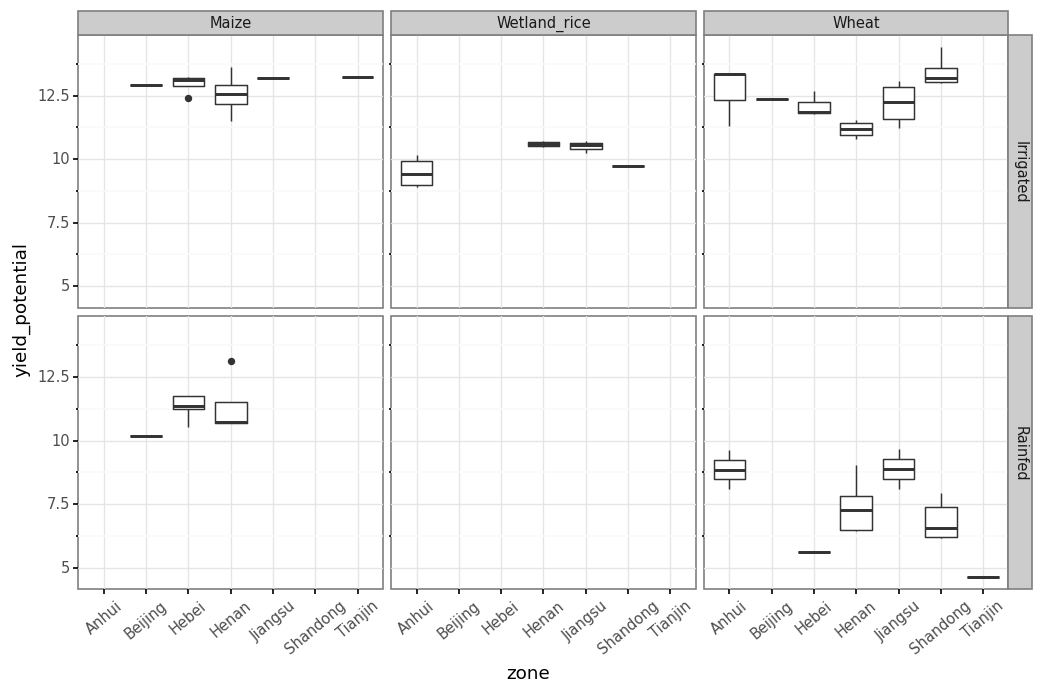

<ggplot: (8750069389225)>

In [ ]:
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 120

(ggplot(GYGA_YP,aes(x='zone',y='yield_potential')) +
 geom_boxplot() +
 facet_grid('water~crop') +
 theme_bw() +
 theme(axis_text_x=element_text(rotation=40))
)

##### Fill the missing values using mean

In [ ]:
# compute the mean values of existing records
GYGA_mean = GYGA_YP.groupby(['zone','crop','water']).mean().reset_index()

In [ ]:
# find missing combinations
All_combinations = itertools.product(GYGA_YP['zone'].unique(),GYGA_YP['crop'].unique(),GYGA_YP['water'].unique())
Exist_combinations = zip(GYGA_mean['zone'],GYGA_mean['crop'],GYGA_mean['water'])

lack_combinations = set(list(All_combinations)) - set(list(Exist_combinations))

In [ ]:
# innitiate an empty df using lack_combinations
null_df = pd.DataFrame({i:[np.nan] for i in lack_combinations}).T.reset_index()
null_df.columns = GYGA_mean.columns

In [ ]:
# function to compute mean YP give crop/water
def get_mean(crop,water):
  mean = GYGA_YP[(GYGA_YP['crop']==crop)&(GYGA_YP['water']==water)]['yield_potential'].mean()
  return mean

# concat null_df with GYGA
null_df['yield_potential'] = null_df.apply(lambda x: get_mean(x['crop'],x['water']),1)

# lastly, fill rainfed-rice with 0
null_df = null_df.fillna(0)

In [ ]:
# connet GYGA_mean with filled null_df
crop_potential = pd.concat([GYGA_mean,null_df]).sort_values(['zone','crop','water']).reset_index(drop=True)
crop_potential['YP_economic_GYGA'] = crop_potential['yield_potential'] * cost_effective_pct

##### Append filling data to orginal GYGA data and making a plot to see the difference

In [ ]:
# append filling data
GYGA_fill = pd.concat([GYGA_YP,null_df])

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype 

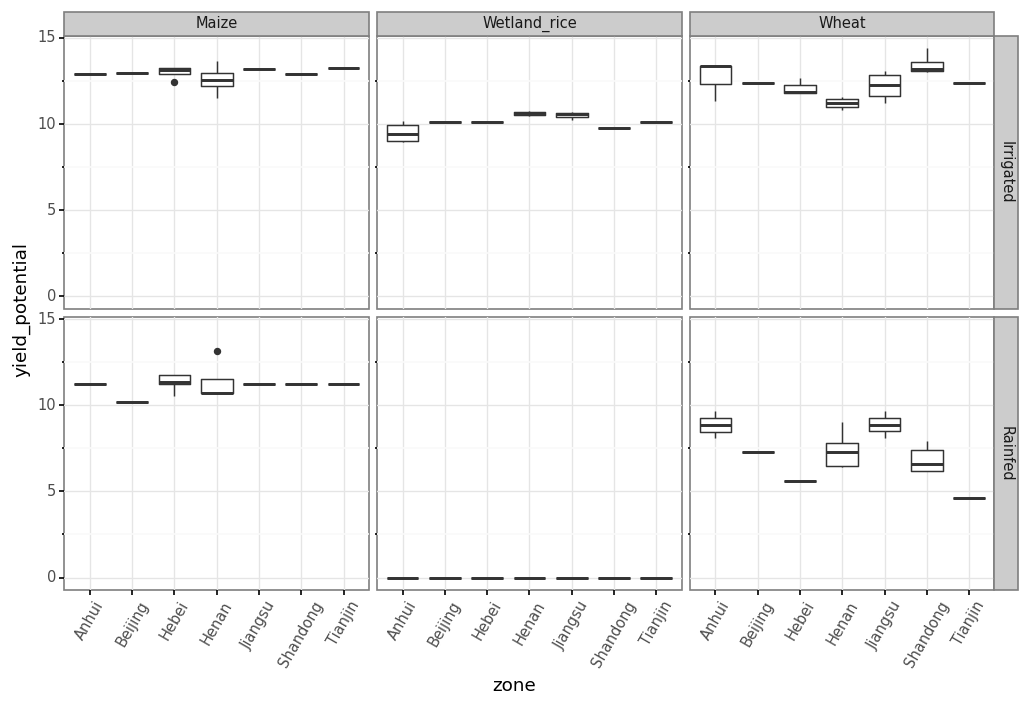

<ggplot: (8750069565493)>

In [ ]:
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 120

(ggplot(GYGA_fill,aes(x='zone',y='yield_potential')) +
 geom_boxplot() +
 facet_grid('water~crop') +
 theme_bw() +
 theme(axis_text_x=element_text(rotation=60))
)

#### 1-2) using GAEZ data:

##### Get the yield potential TIFs

In [8]:
# get necessary data
# 1) actual production
actual_production = get_img_df(img_path = GAEZ_list,
                theme = 'GAEZ_5',
                variable = 'Production',
                time = '2010',
                crop = ['Maize','Wetland_rice','Wheat'],
                water = ['Irrigated','Rainfed'])
# 2) production gap
yield_gap = get_img_df(img_path = GAEZ_list,
                theme = 'GAEZ_6',
                variable = 'Production_Gap',
                time = '2010',
                crop = ['Maize','Wetland_rice','Wheat'],
                water = ['Irrigated','Rainfed'])

# 3) actual yield
actual_yield = get_img_df(img_path = GAEZ_list,
                theme = 'GAEZ_5',
                variable = ['Yield'],
                time = '2010',
                crop = ['Maize','Wetland_rice','Wheat'],
                water = ['Rainfed','Irrigated'])

In [9]:
# merge gap and actual yield
actual_merge_gap = actual_production.merge(yield_gap,on=['time','water','crop'])[['time','water','crop','GEE_path_x','GEE_path_y']]
actual_merge_gap = actual_merge_gap.rename(columns={'GEE_path_x':'production_actual','GEE_path_y':'production_gap'})

actual_merge_gap = actual_merge_gap.merge(actual_yield,on=['time','water','crop'])
actual_merge_gap = actual_merge_gap.rename(columns={'GEE_path':'yield_actual'}).drop(['time','theme','variable'],1)

# compute the achievement ratio
def compute_ratio(img_actual,img_gap):
  img_sum = ee.Image(img_actual).add(img_gap)
  return ee.Image(img_actual).divide(img_sum)

# get the achievement ratio and compute potential yield  
actual_merge_gap['achievement_ratio'] = actual_merge_gap.apply(lambda x:compute_ratio(x['production_actual'],x['production_gap']),1)
actual_merge_gap['potential_yield'] = actual_merge_gap.apply(lambda x:ee.Image(x['yield_actual']).divide(ee.Image(x['achievement_ratio'])),1)

actual_merge_gap

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,water,crop,production_actual,production_gap,yield_actual,achievement_ratio,potential_yield
0,Irrigated,Maize,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,Rainfed,Maize,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,Irrigated,Wetland_rice,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,Rainfed,Wetland_rice,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,Irrigated,Wheat,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
5,Rainfed,Wheat,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


##### Compute the potential_yield stats for each province

In [10]:
stats_df = []

for idx,row in tqdm(actual_merge_gap.iterrows(),total=len(actual_merge_gap)):

  # get infos from actual_merge_gap
  water	= row['water']
  crop = row['crop']

  # if no values in the stats, then it must be rainfed wetland-rice,
  # which have 0 potential yield in the research area
  try:
    # get stats
    stat = ee.Image(row['potential_yield']).reduceRegions(reducer=ee.Reducer.frequencyHistogram(),collection=NCP_provinces,scale=GAEZ_pix_scale).getInfo()

    # extract values
    stas_dict = {i['properties']['EN_Name']:list(i['properties']['histogram'].keys()) for i in stat['features']}

    # convert dict to df
    for k,v in stas_dict.items():

      df = pd.DataFrame({'yield_potential':v})
      df['zone'] = k
      df['water'] = water
      df['crop'] = crop
      stats_df.append(df)

  except:
    vals = [0]*len(city_cn_en)
    df = pd.DataFrame({'yield_potential':vals})
    df['zone'] = list(city_cn_en.values())
    df['water'] = water
    df['crop'] = crop
    stats_df.append(df)

  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
# append potential yield values to df
GAEZ_potential_yield = pd.concat(stats_df).reset_index(drop=True)
GAEZ_potential_yield['yield_potential'] = GAEZ_potential_yield['yield_potential'].astype('float')
GAEZ_potential_yield.head()

,yield_potential,zone,water,crop
0,10.200001,Shandong,Irrigated,Maize
1,10.267001,Shandong,Irrigated,Maize
2,10.318001,Shandong,Irrigated,Maize
3,10.341000,Shandong,Irrigated,Maize
4,10.353000,Shandong,Irrigated,Maize


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype 

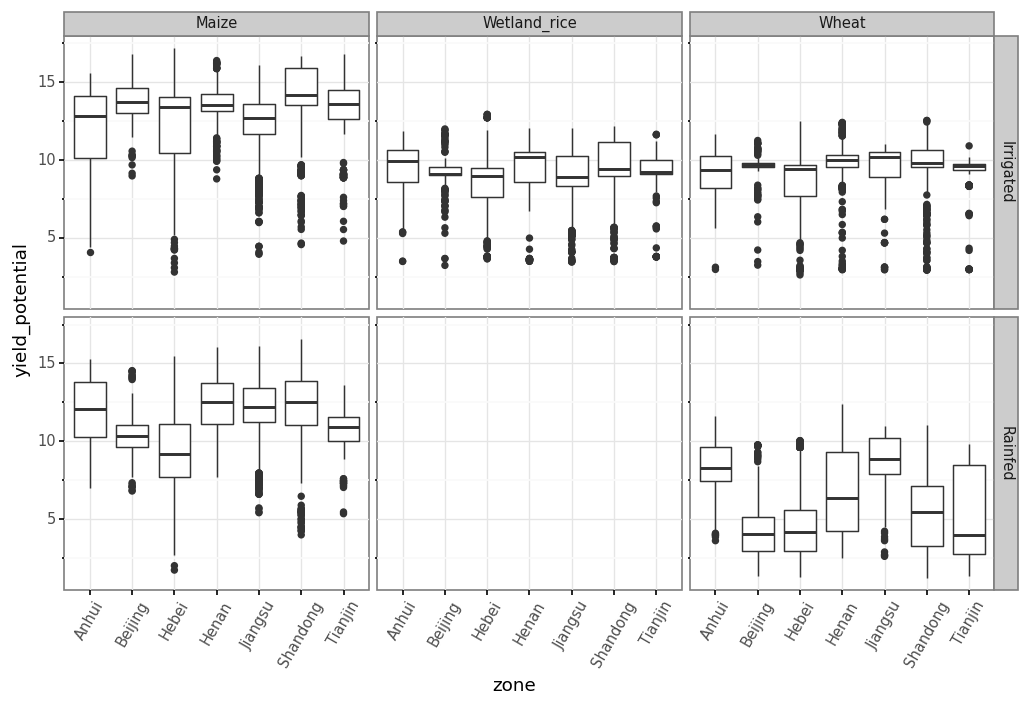

<ggplot: (8742648641661)>

In [12]:
# plot the GAEZ_potential_yield
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 120

(ggplot(GAEZ_potential_yield,aes(x='zone',y='yield_potential')) +
 geom_boxplot() +
 facet_grid('water~crop') +
 theme_bw() +
 theme(axis_text_x=element_text(rotation=60))
)

#### 1-3) Compare GAEZ and GYGA potential yield

In [ ]:
# add GAEZ/GYGA info 
x = GYGA_fill.copy()
y = GAEZ_potential_yield.copy()

x['source'] = 'GYGA'
y['source'] = 'GAEZ'

merge_potential_yield = pd.concat([x,y])

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype 

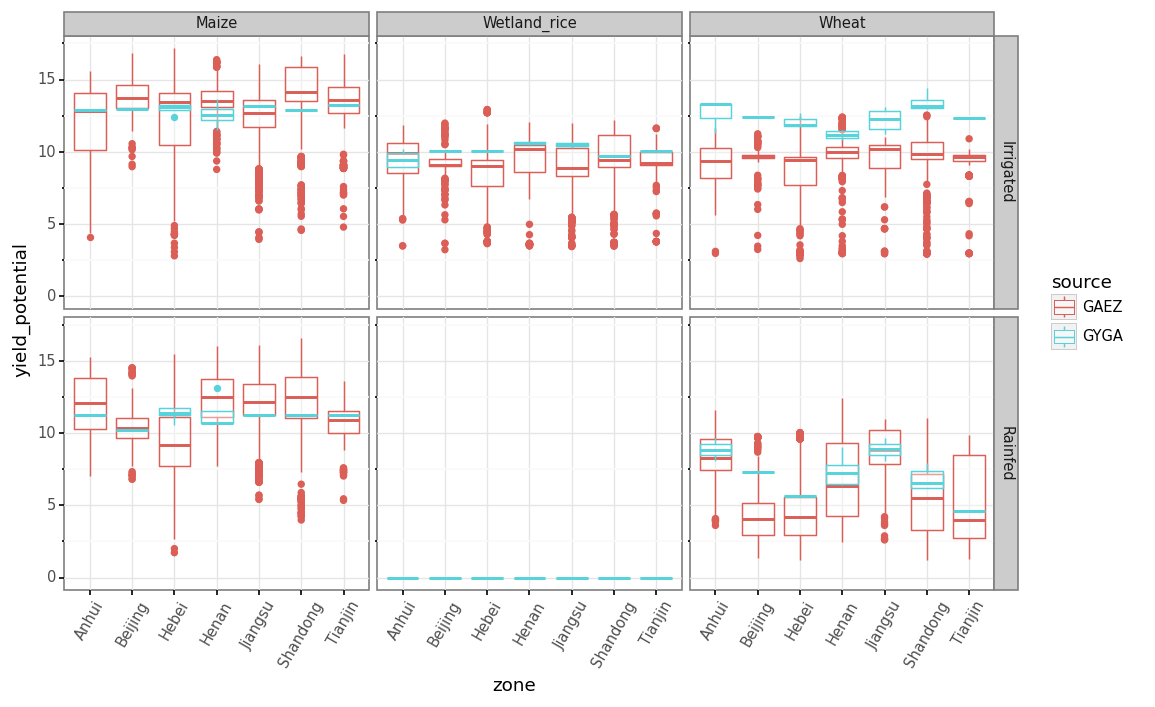

<ggplot: (8750070044069)>

In [ ]:
# plot the GAEZ_potential_yield
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 120

(ggplot(merge_potential_yield,aes(x='zone',y='yield_potential',color='source')) +
 geom_boxplot(position="identity",alpha=0.4) +
 facet_grid('water~crop') +
 theme_bw() +
 theme(axis_text_x=element_text(rotation=60))
)

### 2) Get the regressions on historical crop yield records

In [ ]:
# function to read yearbook csv and orginize data
def read_csv(path,crop):

  # read and reshape data to long format
  df = pd.read_csv(path)
  df = df.set_index('地区')
  df = df.stack().reset_index()
  df.columns = ['zone','Year','Yield']
  df['year'] = df['Year'].apply(lambda x: int(x[:4]))
  df = df.drop('Year',1)
  df['crop'] = crop

  # fitler df and replace CN to EN
  df = df[df['zone'].isin(city_cn_en.keys())]
  df = df.replace(city_cn_en)

  # remove 0s
  df = df[df['Yield']!=0]

  return df

In [ ]:
# read data and concat to a single df
wheat_yield_history = read_csv('../../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield/Provincial_wheat_yield.csv','Wheat')
rice_yield_history = read_csv('../../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield/Provincial_rice_yield.csv','Wetland_rice')
maize_yield_history = read_csv('../../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield/Provincial_maize_yield.csv','Maize')

crop_yield_history = pd.concat([wheat_yield_history,rice_yield_history,maize_yield_history]).reset_index(drop=True)

# # only use the >1980 recores to perform regresion
# crop_yield_history = crop_yield_history[crop_yield_history['year']>1980]

# convert t/ha to kt/ha, so the uint is consistent with GAEZ
crop_yield_history['Yield'] = crop_yield_history['Yield']/1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
pred_dfs = []
regressions = []

# fit a linear model to each of zone/crop combination
for zone in tqdm(crop_yield_history['zone'].unique()):
  for crop in crop_yield_history['crop'].unique():

    df = crop_yield_history[(crop_yield_history['zone']==zone)&(crop_yield_history['crop']==crop)]

    # built the linear regression
    y = df['Yield']
    X = df['year']

    # add a constant column to X, so to get intercept
    X = sm.add_constant(X)

    # construct the model
    mod = sm.OLS(y, X)
    res = mod.fit()
    R2 = res.rsquared_adj

    # record the regression given each Zone/crop
    regressions.append((zone,crop,res.params['const'],res.params['year'],res.rsquared_adj))

    # make predictions with ci

    # 1) preapare input data
    year_in = range(1949,2101)
    X_in = pd.DataFrame({'year':year_in})
    X_in = sm.add_constant(X_in)

    # 2) get prediction
    pred_df = res.get_prediction(X_in).summary_frame(alpha=0.05)

    # 3) append infos
    pred_df['year'] = year_in

    pred_df['zone'] = zone
    pred_df['crop'] = crop

    # record df
    pred_dfs.append(pred_df)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# get predicted yeild
pred_df_cat = pd.concat(pred_dfs).reset_index(drop=True)
pred_df_cat.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,year,zone,crop
0,0.356904,0.174058,0.009667,0.704141,-1.161743,1.875552,1949,Beijing,Wheat
1,0.443897,0.170369,0.104020,0.783773,-1.073085,1.960878,1950,Beijing,Wheat
2,0.530889,0.166708,0.198316,0.863463,-0.984473,2.046251,1951,Beijing,Wheat
3,0.617882,0.163078,0.292550,0.943214,-0.895907,2.131671,1952,Beijing,Wheat
4,0.704875,0.159481,0.386719,1.023030,-0.807389,2.217138,1953,Beijing,Wheat


In [ ]:
# get regresion parameters
reg_parms = pd.DataFrame(regressions)
reg_parms.columns = ['zone','crop','const','year_slope','r2_ads']
reg_parms['label'] = reg_parms.apply(lambda x: f"y = {x['const']:.3f} + {x['year_slope']:.3f} \nR2_adj = {x['r2_ads']:.3f}",1)

reg_parms.head()

,zone,crop,const,year_slope,r2_ads,label
0,Beijing,Wheat,-169.191677,0.086993,0.854138,y = -169.192 + 0.087 \nR2_adj = 0.854
1,Beijing,Wetland_rice,-135.561874,0.070942,0.744091,y = -135.562 + 0.071 \nR2_adj = 0.744
2,Beijing,Maize,-160.961577,0.083220,0.856661,y = -160.962 + 0.083 \nR2_adj = 0.857
3,Tianjin,Wheat,-193.504376,0.098890,0.880939,y = -193.504 + 0.099 \nR2_adj = 0.881
4,Tianjin,Wetland_rice,-180.389724,0.093614,0.671214,y = -180.390 + 0.094 \nR2_adj = 0.671


#### Plot the regression with historical records

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


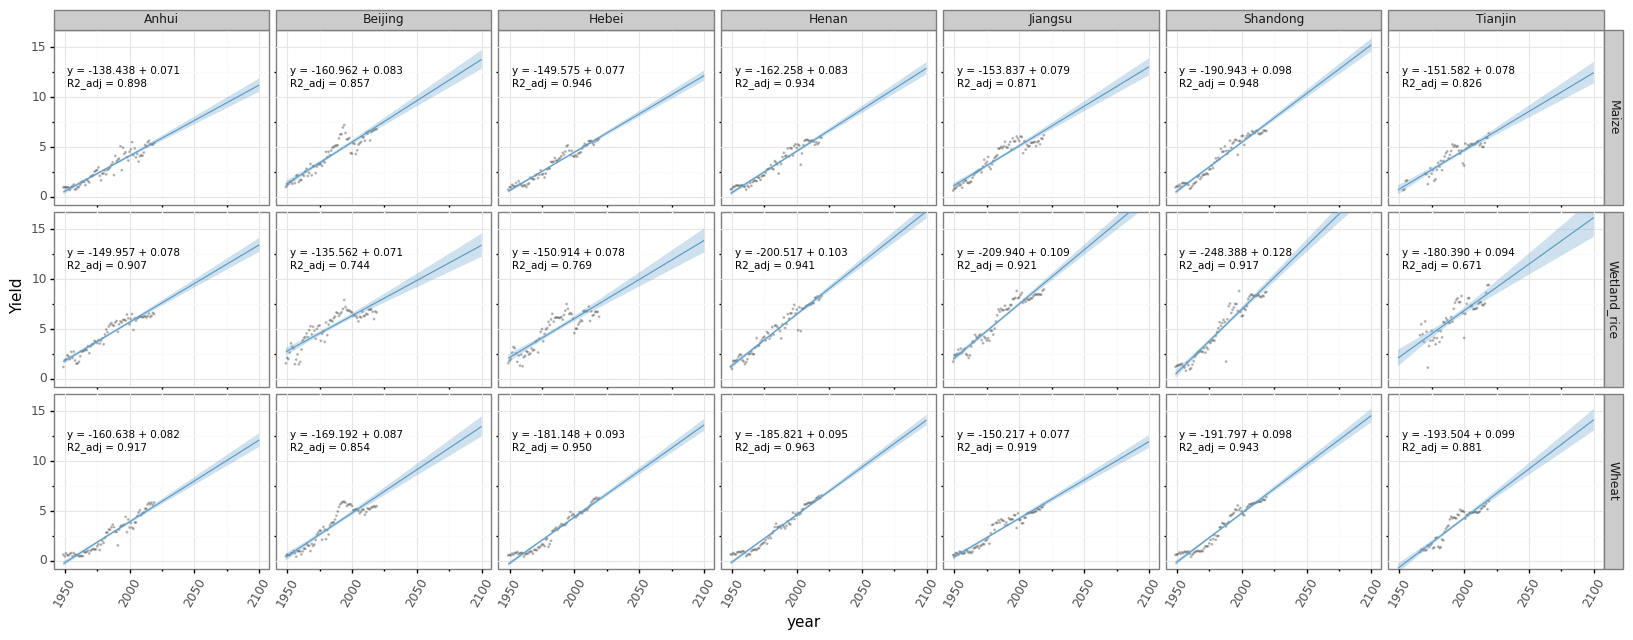

<ggplot: (8750104545405)>

In [ ]:
plotnine.options.figure_size = (20, 7)
plotnine.options.dpi = 100

(ggplot() +
 geom_point(crop_yield_history, aes('year','Yield'),alpha=0.2,size=0.2) +
 geom_line(pred_df_cat, aes('year','mean'),color='#5f9dc8') +
 geom_ribbon(pred_df_cat, aes('year',ymin='mean_ci_lower',ymax='mean_ci_upper'),fill='#5f9dc8',alpha=0.3) +
 geom_text(reg_parms,aes(x=1952,y=12,label='label'),size=7.5,ha='left') +
 facet_grid('crop~zone') +
 coord_cartesian(ylim=(0,16)) +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=60))
)

### 3) Get the actual mean crop yield of 2010 using GAEZ

In [ ]:
# get yield 2010 first
actual_yield = get_img_df(img_path = GAEZ_list,
               theme = 'GAEZ_5',
               variable = ['Yield'],
               time = '2010',
               crop = ['Maize','Wetland_rice','Wheat'],
               water = ['Rainfed','Irrigated'])

# get the mean crop yield of each province
yield_mean = []
for idx,row in tqdm(actual_yield.iterrows(),total=len(actual_yield)):

  # get crop/water info
  crop = row['crop']
  water = row['water']
  img = row['GEE_path']

  # extract stats from GAEZ 
  stats = ee.Image(img).unmask().reduceRegions(collection=NCP_provinces,reducer='mean',scale=GAEZ_pix_scale).getInfo()
  df = pd.DataFrame([i['properties'] for i in stats['features']])[['EN_Name','mean']]

  df['crop'] = crop
  df['water'] = water

  # apppend result_df to list
  yield_mean.append(df)

# concatenate dfs into a single df
yield_mean_df = pd.concat(yield_mean)
yield_mean_df = yield_mean_df.rename(columns={'EN_Name':'zone'})
yield_mean_df.head()

  0%|          | 0/6 [00:00<?, ?it/s]

,zone,mean,crop,water
0,Shandong,5.218688,Maize,Rainfed
1,Henan,5.305166,Maize,Rainfed
2,Beijing,4.427462,Maize,Rainfed
3,Tianjin,4.400797,Maize,Rainfed
4,Hebei,3.999983,Maize,Rainfed


#### predict the 2010-crop-yield to the future

In [ ]:
# function to pred future yield based on the 2010 crop yield
def pred_yield(zone,crop,water):

  # get 2010 crop yield
  yield_2010 = yield_mean_df[(yield_mean_df['zone']==zone)&
                  (yield_mean_df['crop']==crop)&
                  (yield_mean_df['water']==water)]['mean'].tolist()[0]

  # get the yield increase ratio
  increament_ratio = reg_parms[(reg_parms['zone']==zone)&
                  (reg_parms['crop']==crop)]['year_slope'].tolist()[0]

  # preject the increment
  pred_year = np.arange(2010,2101)
  pred_year_distances = pred_year - 2010

  increaments = pred_year_distances * increament_ratio

  crop_yield_pred = yield_2010 + increaments

  # construct the result df
  df = pd.DataFrame({'year':pred_year,'yield_pred':crop_yield_pred})
  df['zone'] = zone
  df['crop'] = crop
  df['water'] = water

  # append confidence interval to the prediction
  df = df.merge(pred_df_cat,on=['year','zone','crop'])[['year','zone','crop','water','yield_pred','mean_se','obs_ci_lower','obs_ci_upper']]

  mean_range = df['mean_se']*1.96
  df['mean_range'] = mean_range
  df['mean_ci_lower'] = df['yield_pred'] - mean_range
  df['mean_ci_upper'] = df['yield_pred'] + mean_range

  obs_range = (df['obs_ci_upper'] - df['obs_ci_lower'])/2
  df['obs_range'] = obs_range
  df['obs_ci_lower'] = df['yield_pred'] - obs_range
  df['obs_ci_upper'] = df['yield_pred'] + obs_range

  return df

In [ ]:
# get crop yield predictions

# 1) get all zone/crop/water combinations
pred_combinations = list(itertools.product(yield_mean_df['zone'].unique(),
                        yield_mean_df['crop'].unique(),
                        yield_mean_df['water'].unique()))

# 2) iterate the combinations and get result df list
pred_dfs = [pred_yield(zone,crop,water) for (zone,crop,water) in pred_combinations]
pred_df = pd.concat(pred_dfs)

# 3) the Wetland_rice yield of rainfed water should always be 0
pred_df.loc[(pred_df['crop']=='Wetland_rice')&(pred_df['water']=='Rainfed'),'yield_pred':'mean_ci_upper'] = 0

In [ ]:
pred_df

,year,zone,crop,water,yield_pred,mean_se,obs_ci_lower,obs_ci_upper,mean_range,mean_ci_lower,mean_ci_upper,obs_range
0,2010,Shandong,Maize,Rainfed,5.218688,0.091142,4.253006,6.184370,0.178638,5.040050,5.397325,0.965682
1,2011,Shandong,Maize,Rainfed,5.316884,0.093319,4.350375,6.283394,0.182906,5.133979,5.499790,0.966510
2,2012,Shandong,Maize,Rainfed,5.415081,0.095527,4.447714,6.382449,0.187232,5.227849,5.602313,0.967367
3,2013,Shandong,Maize,Rainfed,5.513278,0.097762,4.545022,6.481533,0.191613,5.321665,5.704891,0.968256
4,2014,Shandong,Maize,Rainfed,5.611474,0.100023,4.642300,6.580649,0.196044,5.415430,5.807519,0.969174
...,...,...,...,...,...,...,...,...,...,...,...,...
86,2096,Jiangsu,Wheat,Irrigated,11.940771,0.312689,10.807550,13.073992,0.612870,11.327901,12.553641,1.133221
87,2097,Jiangsu,Wheat,Irrigated,12.018002,0.315391,10.881806,13.154199,0.618166,11.399837,12.636168,1.136197
88,2098,Jiangsu,Wheat,Irrigated,12.095234,0.318093,10.956043,13.234425,0.623463,11.471771,12.718697,1.139191
89,2099,Jiangsu,Wheat,Irrigated,12.172466,0.320797,11.030262,13.314670,0.628761,11.543705,12.801227,1.142204


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


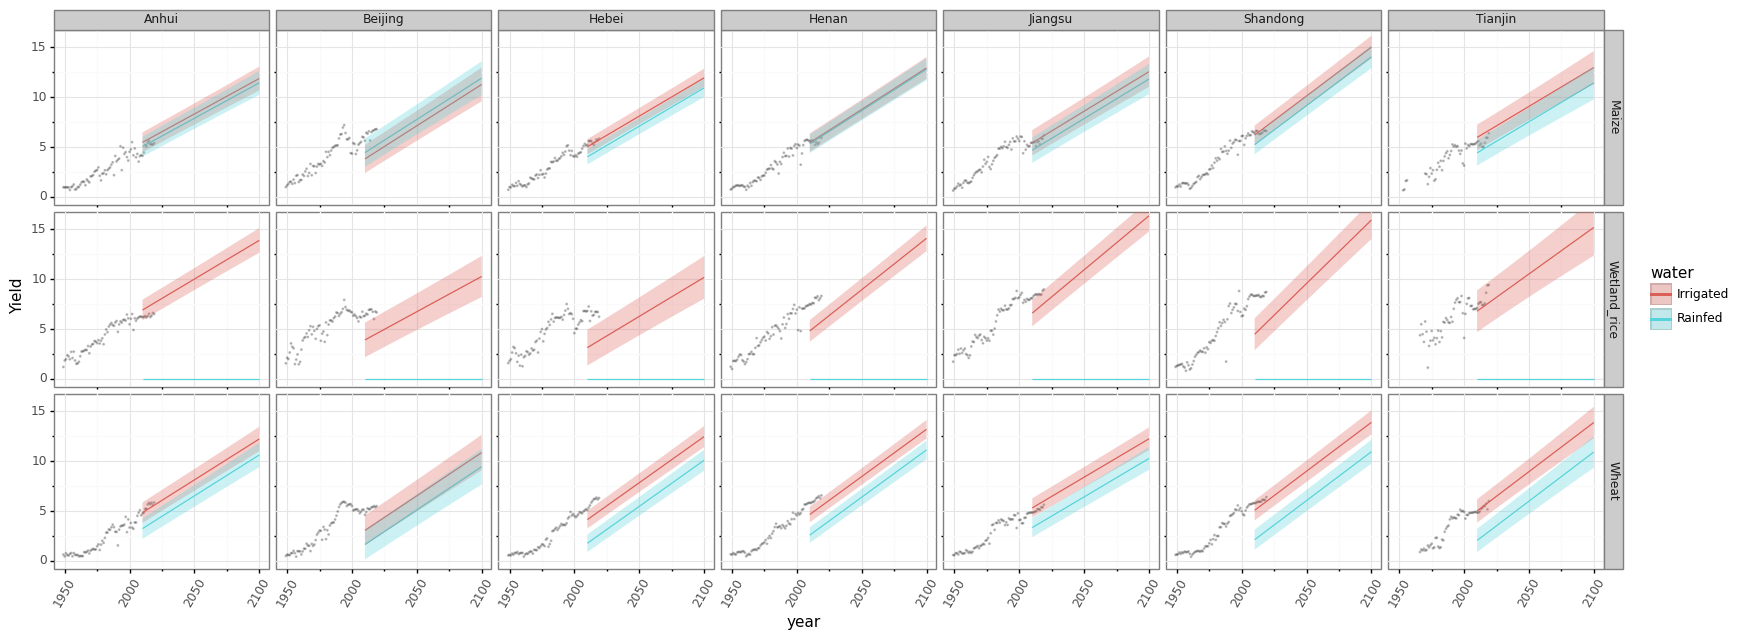

<ggplot: (8750070496937)>

In [ ]:
plotnine.options.figure_size = (20, 7)
plotnine.options.dpi = 100

(ggplot() +
 geom_point(crop_yield_history, aes('year','Yield'),alpha=0.2,size=0.2) +
 geom_line(pred_df, aes('year','yield_pred',color='water')) +
 geom_ribbon(pred_df, aes('year',ymin='obs_ci_lower',ymax='obs_ci_upper',fill='water'),alpha=0.3) +
 facet_grid('crop~zone') +
 coord_cartesian(ylim=(0,16)) +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=60))
)

### 4) Get the year when the crop yield reach the cost-effective threshold

#### 4-1) based on GYGA

In [ ]:
# 1) crop yields of rainfed/irrigated are increasing with the same regression Yield = f(year)
# 2) if the yield reached the coest-effective threshole, it stops increasing
# 3) if a crop reached the coest-effective threshole, it's yield won't decrease

In [ ]:
# function to retrive YP_economic from crop_potential given Province/crop/water
def get_val(df,zone,crop,water,val_name):
  val = df[(df['zone']==zone)&
        (df['crop']==crop)&
        (df['water']==water)][val_name]
  return val.tolist()[0]


# function to compute the year when crop yield reaches the potential
def reach_potential(df,val_name):

  # construct the threshold_name
  distance_name = f'{val_name}_distance'

  # get the difference between pred-yield and cost-effective yeild
  df[val_name] = df.apply(lambda x: get_val(crop_potential,x['zone'],x['crop'],x['water'],val_name),1)
  df[distance_name] = abs(df[val_name] - df['yield_pred'])

  # get the minimum diff_pred_threshold
  min_diff = pd.DataFrame(df.groupby(['zone','crop','water'])[distance_name].min()).reset_index()

  # get the year when the yield_pred is the closest to the yield_economic_potential
  df = min_diff.merge(df[~((df['crop']=='Wetland_rice')&(df['water']=='Rainfed'))],on=['zone','crop','water',distance_name])
  df = df[['zone','crop','water','yield_pred','year',val_name]]

  return df

In [ ]:
# compute the reaching year for GAEZ/GYGA
reach_potential_df = pred_df.copy()
pred_reach_potential_year = reach_potential(reach_potential_df,'YP_economic_GYGA')

In [ ]:
pred_reach_potential_year.head()

,zone,crop,water,yield_pred,year,YP_economic_GYGA
0,Anhui,Maize,Irrigated,10.304570,2078,10.289212
1,Anhui,Maize,Rainfed,9.019031,2066,8.986558
2,Anhui,Wetland_rice,Irrigated,7.597560,2019,7.589555
3,Anhui,Wheat,Irrigated,10.091512,2074,10.126560
4,Anhui,Wheat,Rainfed,7.086112,2057,7.086760


##### construct points to draw lines that indicating the "pred reaches potential"

In [ ]:
# the four points should be like below struture (x,y)
# [year,0]
# [year,yp]
# [year,yp]
# [2100,yp]

pred_reach_potential_year['x'] = pred_reach_potential_year['year'].apply(lambda x:[x]*3 + [2100])
pred_reach_potential_year['y'] = pred_reach_potential_year['YP_economic_GYGA'].apply(lambda x:[0] + [x]*3)

# explode to get coordinates 
coors = pred_reach_potential_year.explode(['x','y'])
coors['x'] = coors['x'].astype('int')
coors['y'] = coors['y'].astype('float')

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


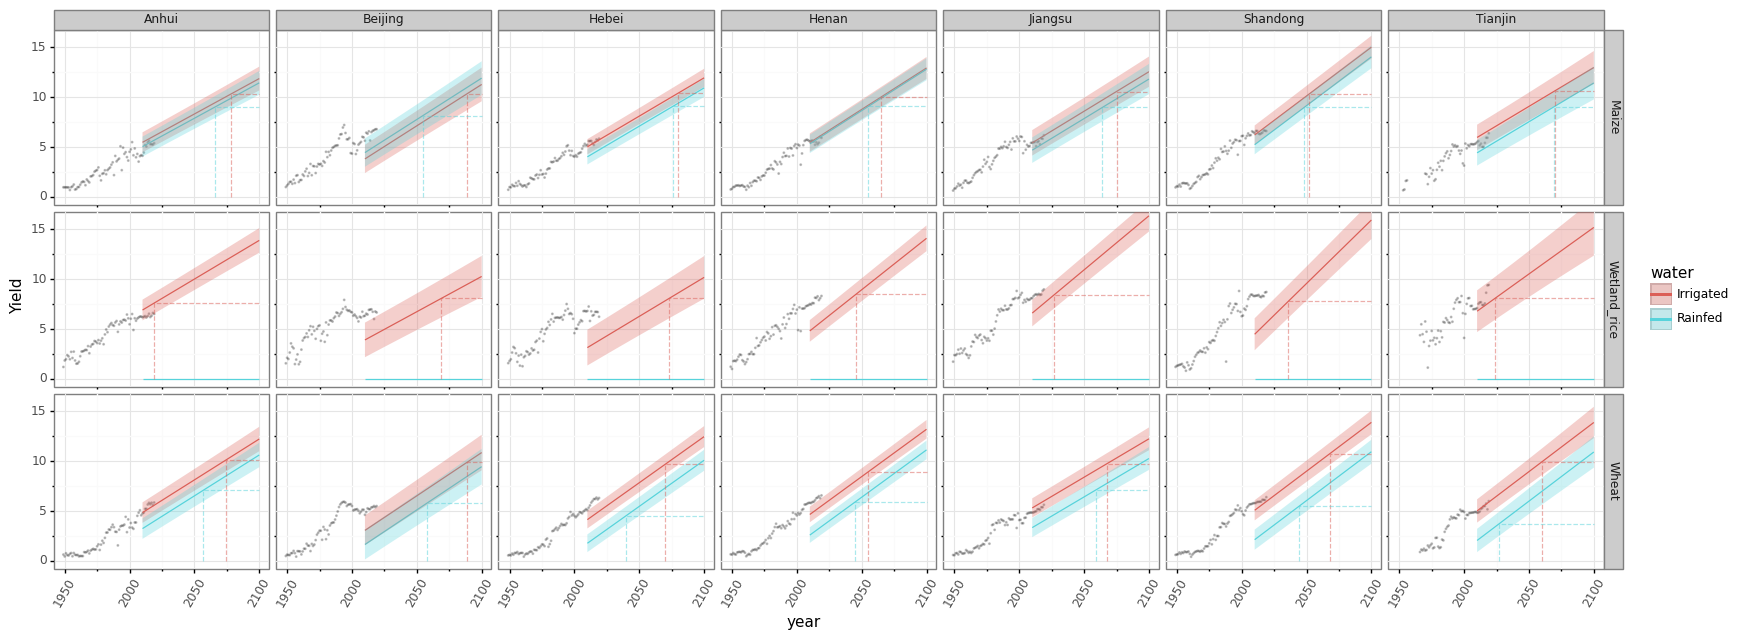

<ggplot: (8750069674697)>

In [ ]:
plotnine.options.figure_size = (20, 7)
plotnine.options.dpi = 100

(ggplot() +
 geom_point(crop_yield_history, aes('year','Yield'),alpha=0.2,size=0.2) +
 geom_line(pred_df, aes('year','yield_pred',color='water')) +
 geom_ribbon(pred_df, aes('year',ymin='obs_ci_lower',ymax='obs_ci_upper',fill='water'),alpha=0.3) +
 geom_line(coors,aes('x','y',color='water'),linetype = '--',alpha=0.5) +
 facet_grid('crop~zone') +
 coord_cartesian(ylim=(0,16)) +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=60))
)

##### Compute the pred-yield/2010-yield ratio

In [ ]:
# first get the mean_se and yield at the threshold pred_reach_potential_year
critical_year = pred_reach_potential_year[['zone','crop','water','year','YP_economic_GYGA']].copy()

critical_year['mean_se'] = critical_year.apply(lambda x:pred_df[(pred_df['zone']==x['zone'])&
                                   (pred_df['crop']==x['crop'])&
                                   (pred_df['water']==x['water'])&
                                   (pred_df['year']==x['year'])]['mean_se'].tolist()[0],1)

critical_year['obs_range'] = critical_year.apply(lambda x:pred_df[(pred_df['zone']==x['zone'])&
                                   (pred_df['crop']==x['crop'])&
                                   (pred_df['water']==x['water'])&
                                   (pred_df['year']==x['year'])]['obs_range'].tolist()[0],1)

In [ ]:
# function to compute the ratio
def compute_ratio_ci(row):

  # filter the row with 
  zone = row['zone']
  crop = row['crop']
  water = row['water']
  year = row['year']
  pred = row['yield_pred']


  # return 0 if get Wetland_rice of Rainfed
  if (crop == 'Wetland_rice') & (water == 'Rainfed'):
    return 0,0,0

  else:
    # get the year when yeild_pred reaches the potential yield
    year_reach = get_val(critical_year,zone,crop,water,'year')   

    # get the 2010 crop yield
    yield_2010 = get_val(yield_mean_df,zone,crop,water,'mean')

    # get the cost-effective potential yeild
    yield_potential = get_val(critical_year,zone,crop,water,'YP_economic_GYGA')


    # compute the ratio
    if year <= year_reach:
      ratio = pred / yield_2010
      se = row['mean_se']
      obs_ci = row['obs_range']/yield_2010
      mean_ci = se/yield_2010 * 1.96
    else:
      ratio = yield_potential / yield_2010
      se = get_val(critical_year,zone,crop,water,'mean_se')
      obs_ci = get_val(critical_year,zone,crop,water,'obs_range')/yield_2010
      mean_ci = se/yield_2010 * 1.96

    return ratio,mean_ci,obs_ci

In [ ]:
# compute the pred_yield_to_2010_ratio and se
pred_ratios = pred_df[['year', 'zone', 'crop', 'water', 'yield_pred', 'mean_se', 'obs_range']].copy()

# get ratios anc confidence intervals
result = pred_ratios.apply(lambda x:compute_ratio_ci(x),1)
result_df = pd.DataFrame([i for i in result])
ratios,mean_cis,obs_cis = result_df[0].values,result_df[1].values,result_df[2].values

# get the confidence interval
pred_ratios['mean_ratio'] = ratios
pred_ratios['mean_cis'] = mean_cis
pred_ratios['obs_cis'] = obs_cis

pred_ratios['mean_ratio_upper'] = ratios + mean_cis
pred_ratios['mean_ratio_lower'] = ratios - mean_cis
pred_ratios['obs_ratio_upper'] = ratios + obs_cis
pred_ratios['obs_ratio_lower'] = ratios - obs_cis

# drop unnecessary cols
pred_ratios = pred_ratios.drop(['yield_pred','mean_se','obs_range','yield_pred','yield_pred'],1)

# save to disk
pred_ratios.to_csv('./result_csv/future_yield_ratios.csv',index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
pred_ratios

,year,zone,crop,water,mean_ratio,mean_cis,obs_cis,mean_ratio_upper,mean_ratio_lower,obs_ratio_upper,obs_ratio_lower
0,2010,Shandong,Maize,Rainfed,1.000000,0.031754,0.156723,1.031754,0.968246,1.156723,0.843277
1,2011,Shandong,Maize,Rainfed,1.013872,0.033192,0.157041,1.047064,0.980679,1.170913,0.856830
2,2012,Shandong,Maize,Rainfed,1.027743,0.034699,0.157389,1.062443,0.993044,1.185132,0.870354
3,2013,Shandong,Maize,Rainfed,1.041615,0.036266,0.157766,1.077882,1.005349,1.199381,0.883849
4,2014,Shandong,Maize,Rainfed,1.055487,0.037886,0.158172,1.093373,1.017601,1.213659,0.897315
...,...,...,...,...,...,...,...,...,...,...,...
86,2096,Jiangsu,Wheat,Irrigated,1.731927,0.169584,0.216759,1.901510,1.562343,1.948686,1.515168
87,2097,Jiangsu,Wheat,Irrigated,1.740438,0.171326,0.218219,1.911764,1.569111,1.958657,1.522219
88,2098,Jiangsu,Wheat,Irrigated,1.748948,0.173069,0.219684,1.922018,1.575879,1.968632,1.529265
89,2099,Jiangsu,Wheat,Irrigated,1.757459,0.174812,0.221154,1.932272,1.582647,1.978613,1.536306


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


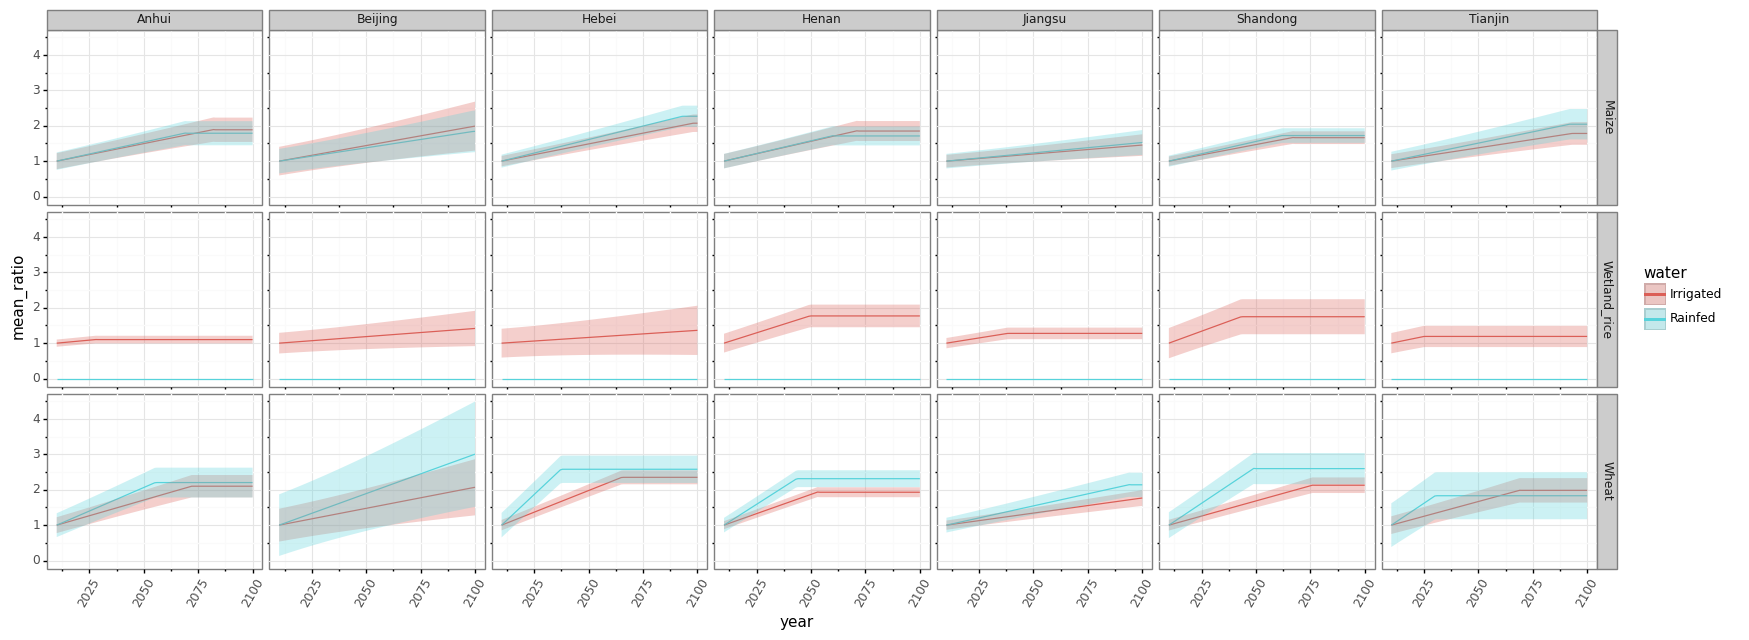

<ggplot: (8746884524345)>

In [ ]:
plotnine.options.figure_size = (20, 7)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(pred_ratios, aes('year','mean_ratio',color='water')) +
 geom_ribbon(pred_ratios, aes('year',ymin='obs_ratio_lower',ymax='obs_ratio_upper',fill='water'),alpha=0.3) +
 facet_grid('crop~zone') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=60))
)

#### 4-2) based on GAEZ

In [ ]:
# function to increase the yield_img and mask out the pixels
# that are larger/equals to the potential yield
def yield_increase_updata(yield_img,potential_img,increament,zone):

  # 1) convert parameters to GEE_object
  yield_img = ee.Image(yield_img).clip(zone)
  potential_img = ee.Image(potential_img).clip(zone)
  increament = ee.Image(increament)

  # 2) identify the pixels that not reach the potential yield
  mask = yield_img.lt(potential_img)

  # 3) allocate increment to the mask
  increament = increament.mask(mask).unmask()

  # 4) add the increment to the original yield_img
  yield_increase = yield_img.add(increament)

  return yield_increase

In [ ]:
# copy data in case mess them up
increament_yield = reg_parms.copy()[['zone', 'crop', 'year_slope']]
yield_2010 = actual_yield.copy()
future_yield = pred_df.copy()
potential_yield = actual_merge_gap.copy()[['water', 'crop', 'potential_yield']]

In [ ]:
GAEZ_future_yield = {}

# loop through each province
for p in city_cn_en.values():
  p_gee = NCP_provinces.filter(ee.Filter.equals('EN_Name',p))

  # loop through each crop
  for crop in yield_2010['crop'].unique():
    yield_increment = increament_yield[(increament_yield['zone']==p)&(increament_yield['crop']==crop)]['year_slope'].tolist()[0]

    for water in yield_2010['water'].unique():
      # get the yield_2010 and potential_img
      yield_2010_img = ee.Image(yield_2010[(yield_2010['crop']==crop)&(yield_2010['water']==water)]['GEE_path'].tolist()[0])
      potential_img = potential_yield[(potential_yield['crop']==crop)&(potential_yield['water']==water)]['potential_yield'].tolist()[0]


      # loop throuth pred years
      for year in range(2011,2101):
        distance_to_2010 = year - 2010
        yield_increse = yield_increment * distance_to_2010
        yield_img = yield_increase_updata(yield_2010_img,potential_img,yield_increse,p_gee)

        # append confidence interval
        mean_range,obs_range = future_yield[(future_yield['year']==year)&(future_yield['zone']==p)&
                            (future_yield['crop']==crop)&(future_yield['water']==water)]\
                            [['mean_range','obs_range']].values[0]

        yield_img_mean_upper = yield_img.add(ee.Image(mean_range))
        yield_img_mean_lower = yield_img.subtract(ee.Image(mean_range))
        yield_img_obs_upper = yield_img.add(ee.Image(obs_range))
        yield_img_obs_lower = yield_img.subtract(ee.Image(obs_range))

        # record the result
        GAEZ_future_yield[p,crop,water,year] = {}
        GAEZ_future_yield[p,crop,water,year].update({'yield_2010_img':yield_2010_img})
        GAEZ_future_yield[p,crop,water,year].update({'increament':yield_increse})
        GAEZ_future_yield[p,crop,water,year].update({'yield_img':ee.Image(yield_img)})
        GAEZ_future_yield[p,crop,water,year].update({'yield_img_mean_upper':ee.Image(yield_img_mean_upper)})
        GAEZ_future_yield[p,crop,water,year].update({'yield_img_mean_lower':ee.Image(yield_img_mean_lower)})
        GAEZ_future_yield[p,crop,water,year].update({'yield_img_obs_upper':ee.Image(yield_img_obs_upper)})
        GAEZ_future_yield[p,crop,water,year].update({'yield_img_obs_lower':ee.Image(yield_img_obs_lower)})

In [ ]:
# reorganize the dict to a df
GAEZ_future_yield_df = pd.DataFrame(GAEZ_future_yield).T.reset_index()
GAEZ_future_yield_df = GAEZ_future_yield_df.rename(columns={'level_0':'zone','level_1':'crop','level_2':'water','level_3':'year'})

# save to disk
GAEZ_future_yield_df.to_pickle('./result_csv/GAEZ_future_yield_df.pkl')

GAEZ_future_yield_df.head()

,zone,crop,water,year,yield_2010_img,increament,yield_img,yield_img_mean_upper,yield_img_mean_lower,yield_img_obs_upper,yield_img_obs_lower
0,Beijing,Maize,Rainfed,2011,"ee.Image({\n ""functionInvocationValue"": {\n ...",0.041621,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,Beijing,Maize,Rainfed,2012,"ee.Image({\n ""functionInvocationValue"": {\n ...",0.083242,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,Beijing,Maize,Rainfed,2013,"ee.Image({\n ""functionInvocationValue"": {\n ...",0.124863,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,Beijing,Maize,Rainfed,2014,"ee.Image({\n ""functionInvocationValue"": {\n ...",0.166484,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,Beijing,Maize,Rainfed,2015,"ee.Image({\n ""functionInvocationValue"": {\n ...",0.208105,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [ ]:
# # sanity check to see if the pred_img - pred_img = increament
# idx=100

# # fetch the imgs
# img_pred = GAEZ_future_yield_df.iloc[idx]['yield_img']
# img_2010 = GAEZ_future_yield_df.iloc[idx]['yield_2010_img']
# increament = GAEZ_future_yield_df.iloc[idx]['increament']
# zone = GAEZ_future_yield_df.iloc[idx]['zone']

# # import some geometry
# pts = ee.Geometry.MultiPoint(
#     [[116.49102909464443, 39.64809696628419],
#     [116.56244022745693, 39.69672042581435],
#     [116.63659794230068, 39.789643831366114]])

# shp = NCP_provinces.filterMetadata('EN_Name','equals',zone)

# # get values
# pred_df = pd.DataFrame(ee.ImageCollection(img_pred).getRegion(geometry=pts,scale=GAEZ_pix_scale).getInfo()).drop(0)
# yield_2010_df = pd.DataFrame(ee.ImageCollection(img_2010).getRegion(geometry=pts,scale=GAEZ_pix_scale).getInfo()).drop(0)
# diff = pred_df[4].mean() - yield_2010_df[4].mean() 

# # get pixel count
# pred_count = img_pred.reduceRegion(reducer='count',geometry=shp.geometry(),scale=GAEZ_pix_scale).get('b1').getInfo()
# yield_2010_count = img_2010.reduceRegion(reducer='count',geometry=shp.geometry(),scale=GAEZ_pix_scale).get('b1').getInfo()

# print(f"The diff {diff:03f}, the increament {increament:03f}")
# print(f"The pred_count {pred_count}, the 2010_count {yield_2010_count}")

The diff 0.457830, the increament 0.457830
The pred_count 141, the 2010_count 141
